## Imports

In [59]:
# referenced https://srush.github.io/annotated-s4/#part-1b-addressing-long-range-dependencies-with-hippo

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import fftconvolve

## Quilee test SSSM

In [60]:
class SSM(torch.nn.Module):
    """State Space Model.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (batch, seq_len, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # SSM parameters
        self.A = torch.nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.A.weight = torch.nn.Parameter(self.make_HiPPO(self.hidden_size), requires_grad=False)
        self.B = torch.nn.Linear(self.input_size, self.hidden_size, bias=False)
        self.step = torch.nn.Parameter(torch.ones(1, hidden_size))
        
    def discretize(self):
        I = torch.eye(self.hidden_size)
        BL = torch.linalg.inv(I - (self.step / 2.0) * self.A.weight)
        Ab = BL @ (I + (self.step / 2.0) * self.A.weight)
        Bb = (BL * self.step) @ self.B.weight
        self.A.weight.data = Ab
        self.B.weight.data = Bb
        return None

    def make_HiPPO(self, N):
        P = torch.sqrt(1 + 2 * torch.arange(N))
        A = P.unsqueeze(-1) @ P.unsqueeze(0)
        A = torch.tril(A) - torch.diag(torch.arange(N))
        return -A

    def init_hidden(self, input_shape):
        device = next(self.parameters()).device
        batch_size = input_shape[0]  # because batch_first=True
        hidden = torch.zeros(batch_size, self.hidden_size).to(device)
        return hidden

    def recurrence(self, input, hidden):
        """
        Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        # print(f"hidden: {hidden.shape} \n input: {input.shape}")
        # print(f"A: {type(self.A), self.A.weight.shape} \n Bb: {type(self.A), self.A.weight.shape}")
        h_new = self.A(hidden) + self.B(input)
        return h_new

    def forward(self, input, hidden=None):
        """
        Propagate input through the network. NOTE: Because we use
        batch_first=True, input has shape (batch, seq_len, input_size).
        """
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape)
        # Loop through time
        output = []
        steps = range(input.size(1))
        self.discretize()
        for i in steps:
            # `hidden` is just the most recent state
            hidden = self.recurrence(input[:, i, :], hidden) 
            output.append(hidden)
        # Stack together output from all time steps
        output = torch.stack(output, dim=1)  # (batch, seq_len, hidden_size)
        return output, hidden
    
    def causal_convolution(u, K):
        assert K.ndim == u.ndim and K.shape[1] == u.shape[1], "Signals do not have the same shapes."
        return fftconvolve(u, K, mode="full")
    
    def K_conv(self, L):
        """L is the sequence length."""
        Ab, Bb = self.discretize()
        K = torch.tensor([(torch.linalg.matrix_power(Ab, l) @ Bb).reshape() for l in range(L)])
        return K
    
    

In [61]:
N = 50
timesteps = 10
num_channels = 8
batch_size = 2

# test 1
model = SSM(input_size=num_channels, hidden_size=N)

input_signal = torch.randn((batch_size, timesteps, num_channels))
print(f'Input signal shape: {input_signal.shape}')

output_signal, hidden_state = model(input_signal)
print(f'Output signal shape: {output_signal.shape}\n')


plt.plot(input_signal[0, :, 0], label='Input signal')
plt.plot(output_signal[0, :, 0].detach().cpu(), label='Output signal')
plt.legend()

Input signal shape: torch.Size([2, 10, 8])
Output signal shape: torch.Size([2, 10, 50])



In [ ]:
# def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    #     ssm = random_SSM(rng, N)
    #     u = jax.random.uniform(rng, (L,))
    #     jax.random.split(rng, 3)
    #     # RNN
    #     rec = run_SSM(*ssm, u)
    #     # CNN
    #     ssmb = discretize(*ssm, step=step)
    #     conv = causal_convolution(u, K_conv(*ssmb, L))
    #     # Check
    #     assert np.allclose(rec.ravel(), conv.ravel())

## Mass example

In [63]:
def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]])
    B = torch.tensor([[0], [1.0 / m]])
    C = torch.tensor([[1.0, 0]])
    
    return A, B, C

def example_force(t):
    x = torch.sin(10 * t)
    return x * (x > 0.5)

Input signal shape: torch.Size([1, 100, 1])
Output signal shape: torch.Size([1, 100, 2])


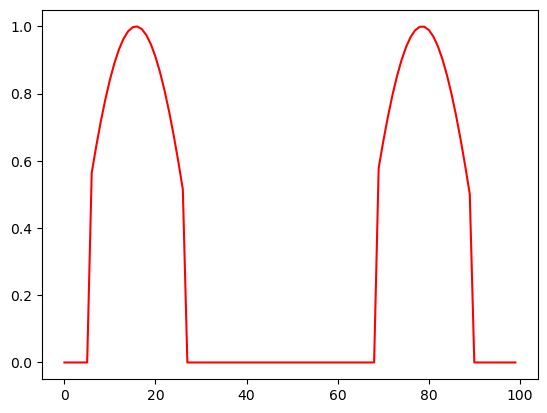

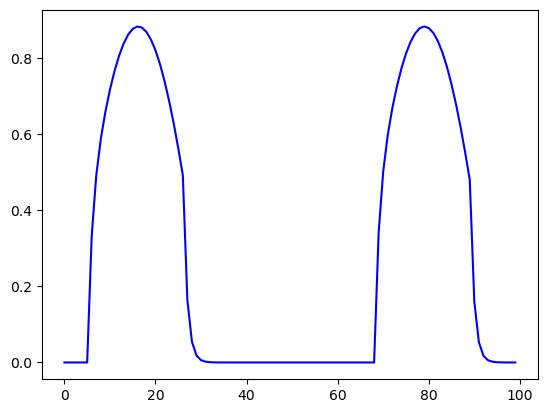

In [64]:
A, B, C = example_mass(k=40, b=5, m=1)

L = 100
step = 1.0 / L
ks = torch.arange(L)
u = example_force(ks * step)

# Approximation of y(t).
model = SSM(input_size=1, hidden_size=2)

input_signal = u.view(1, -1, 1)
print(f'Input signal shape: {input_signal.shape}')

output_signal, hidden_state = model(input_signal)
print(f'Output signal shape: {output_signal.shape}')


plt.figure()
plt.plot(ks, input_signal.view(-1).numpy(), color="red")
plt.figure()
plt.plot(ks, output_signal[0,:,0].view(-1).detach().numpy(), color="blue")

## Random SSM

In [65]:
class RandomSSM(torch.nn.Module):
    def __init__(self, N, num_channels, fixed_length=10, A=None, B=None, C=None):
        super(RandomSSM, self).__init__()

        # maps time series output to previous timestep N-dim latent state and projects back to output time series data
        if A is None:
            A = torch.randn((N, N))
        if B is None:
            B = torch.randn((N, 1))

        self.N = N
        self.num_channels = num_channels

        # assuming fixed length sequences
        self.A, self.B, self.C = self.discretize(A, B, C, step=1.0/fixed_length)

    def forward(self, u):
        x = torch.zeros((u.shape[0], u.shape[1]+1, self.N))
        
        # u shape - B, T, C
        # recurrency via iteration
        for channel in range(u.shape[-1]):      # for proper mapping shape broadcasting
            for timestep in range(u.shape[1]):
                x[:, timestep+1] = (self.A(x[:, timestep]).view(-1, self.N)
                    + self.B(u[:, timestep, channel].view(-1, 1))).view(-1, self.N)
        
        # final projection back to proper time series data
        y = self.C(x[:, 1:])
        
        return y

    def discretize(self, A, B, C=None, step=1):
        identity_matrix = torch.eye(self.N)

        # discretize via bilinear transform https://en.wikipedia.org/wiki/Bilinear_transform
        BL = torch.inverse(identity_matrix - (step / 2.0) * A)
        A_discrete = BL @ (identity_matrix + (step / 2.0) * A)
        B_discrete = (BL * step) @ B

        A_final = torch.nn.Linear(*A.shape, bias=False)
        A_final.weight = torch.nn.Parameter(A_discrete)
        B_final = torch.nn.Linear(*B.shape, bias=False)
        B_final.weight = torch.nn.Parameter(B_discrete)

        # allows for conditional initialization of C
        if C is None:
            C_final = torch.nn.Linear(self.N, self.num_channels, bias=False)
        else:
            C_final = torch.nn.Linear(*C.shape, bias=False)
            C_final.weight = torch.nn.Parameter(C)

        return A_final, B_final, C_final

In [66]:
N = 50
timesteps = 10
num_channels = 8

# test 1
model = RandomSSM(N, num_channels, timesteps)

input_signal = torch.randn((4, timesteps, num_channels))
print(f'Input signal shape: {input_signal.shape}')

output_signal = model(input_signal)
print(f'Output signal shape: {output_signal.shape}\n')

# test 2
A = torch.randn((N, N))
B = torch.randn((N, 1))
C = torch.randn((num_channels, N))

model = RandomSSM(N, num_channels, timesteps, A, B, C)

input_signal = torch.randn((4, timesteps, num_channels))
print(f'Input signal shape: {input_signal.shape}')

output_signal = model(input_signal)
print(f'Output signal shape: {output_signal.shape}')

Input signal shape: torch.Size([4, 10, 8])
Output signal shape: torch.Size([4, 10, 8])

Input signal shape: torch.Size([4, 10, 8])
Output signal shape: torch.Size([4, 10, 8])


## Mass example

In [67]:
def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]])
    B = torch.tensor([[0], [1.0 / m]])
    C = torch.tensor([[1.0, 0]])
    
    return A, B, C

def example_force(t):
    x = torch.sin(10 * t)
    return x * (x > 0.5)

Input signal shape: torch.Size([1, 100, 1])
Output signal shape: torch.Size([1, 100, 1])


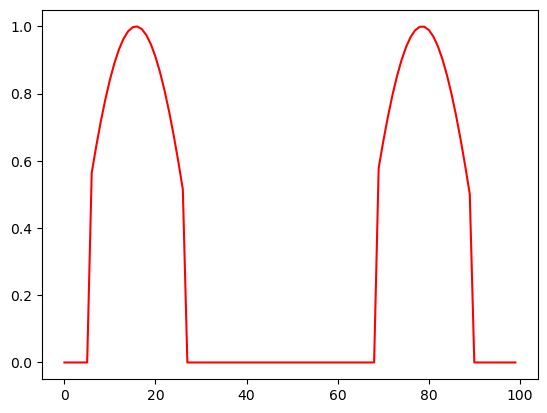

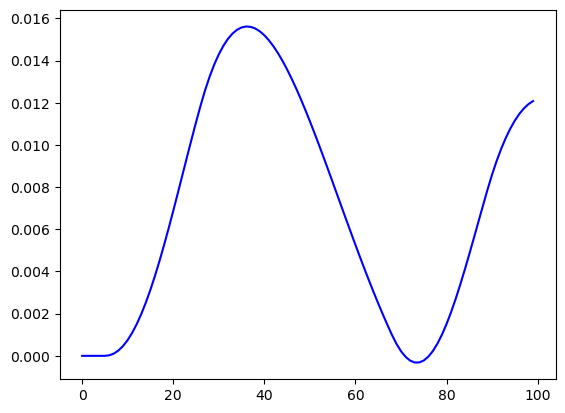

In [68]:
A, B, C = example_mass(k=40, b=5, m=1)

L = 100
step = 1.0 / L
ks = torch.arange(L)
u = example_force(ks * step)

# Approximation of y(t).
model = RandomSSM(2, 1, L, A, B, C)

input_signal = u.view(1, -1, 1)
print(f'Input signal shape: {input_signal.shape}')

output_signal = model(input_signal)
print(f'Output signal shape: {output_signal.shape}')


plt.figure()
plt.plot(ks, input_signal.view(-1).numpy(), color="red")
plt.figure()
plt.plot(ks, output_signal[0,:,0].view(-1).detach().numpy(), color="blue")